In [1]:
import sys
sys.path.append("../../")
from multiprocessing import Pool
import tqdm
import pickle
from pathlib import Path
from contextlib import closing
from rdkit import Chem
import numpy as np
import pandas as pd

# Load fragmentation results

In [2]:
%%time
fragments_path = Path("/net/cci/cschlick/Filtered_COD3/fragmentation_results.pkl")
with fragments_path.open("rb") as fh:
  fragmentation_results = pickle.load(fh)

CPU times: user 26.6 s, sys: 7.68 s, total: 34.3 s
Wall time: 34.5 s


## Featurize fragments

In [5]:
from phenixml.featurizers.ani_featurizer import ANIFeaturizer

In [6]:
# elements and parameters
covalent_organic = ["O","C","H","N","P","S","Cl","B","F","I","Br"]
metals = ["Na","K","Ca","Fe","Mn","Zn","Mg","Cu","Co"]

params = {'radial_cutoff': 4.6,
 'radial_nu': 32,
 'radial_probes': [0.7,
                  1.4,
                  1.9,
                  2.4,
                  3.2,
                  3.8,
                  4.4],
 'angular_cutoff': 3.1,
 'angular_nu': 4,
 'angular_probes': [0.0, 1.57, 3.14, 4.71],
 'angular_radial_probes': [0.7,1.4,1.9,2.4],
 'angular_zeta': 8,
 'min_probed_value': 0.0,
 'exclude_hydrogens': False,
 'elements_considered': covalent_organic}

In [7]:
mode = "bond"
if mode == "angle":
  fragment_key = "angle_fragments"
elif mode == "bond":
  fragment_key = "bond_fragments"

def worker(result):
  frags = result[fragment_key]
  featurizer = ANIFeaturizer.from_bond_angle_frags(frags,params)
  if featurizer is None:
    return None
  else:
    return (featurizer.featurize(),frags)



In [8]:
work = fragmentation_results
with closing(Pool(processes=32)) as pool:
  features = []
  for result in tqdm.tqdm(pool.map(worker, work), total=len(work)):
      features.append(result)
  pool.terminate()

100%|██████████| 63018/63018 [00:00<00:00, 1665353.93it/s]


In [34]:
X = []
bond_fragments = []
for i,feature in enumerate(features):
  if feature is not None:
    bond_fragments+=fragmentation_results[i][fragment_key]
    X.append(feature)
X = np.vstack(X)
print(X.shape)

(32954, 1133)


In [35]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [36]:
if mode =="bond":

  y =  np.array([frag.properties["bond_length"] for frag in bond_fragments])
  space = np.arange(X.shape[0])
  train, test = train_test_split(space,test_size=0.2)
  frags_train, frags_test = [bond_fragments[i] for i in train], [bond_fragments[i] for i in test]
elif mode == "angle":
  X = angle_features
  y =  np.array([frag.properties["angle_deg"] for frag in angle_fragments])
  train, test = train_test_split(space,test_size=0.2)
  frags_train, frags_test = [angle_fragments[i] for i in train], [angle_fragments[i] for i in test]
  
X_train, X_test = X[train],X[test]
y_train, y_test = y[train],y[test]

In [45]:
regressor = RandomForestRegressor(n_estimators=100,min_samples_split=100,min_samples_leaf=20, random_state=0,n_jobs=-1)

In [52]:
import joblib
import os
joblib.dump(regressor, "tmp.joblib", compress=3)  # compression is ON!
print(f"Compressed Random Forest: {np.round(os.path.getsize('tmp.joblib') / 1024 / 1024, 2) } MB")

Compressed Random Forest: 1.29 MB


In [46]:
%%time
regressor.fit(X_train,y_train)

CPU times: user 9min 23s, sys: 1.2 s, total: 9min 25s
Wall time: 8.32 s


RandomForestRegressor(min_samples_leaf=20, min_samples_split=100, n_jobs=-1,
                      random_state=0)

In [47]:
y_pred = regressor.predict(X_test)

Text(0, 0.5, 'Predicted')

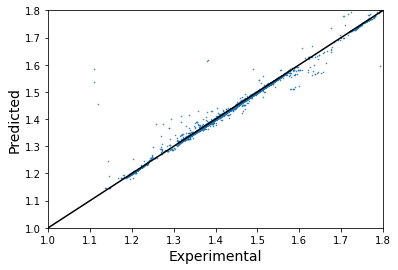

In [48]:
df = pd.DataFrame({"dists":y_test.flatten(),"pred":y_pred.flatten()})
ax = df.plot.scatter("dists","pred",s=0.25)
if mode == "bond":
  ax.set_xlim(1,1.8)
  ax.set_ylim(1,1.8)
elif mode == "angle":
  ax.set_xlim(50,140)
  ax.set_ylim(50,140)
ax.plot([0,200],[0,200],color="black")
ax.set_xlabel("Experimental",fontsize=14)
ax.set_ylabel("Predicted",fontsize=14)

In [ ]:
from sklearn.metrics import mean_squared_error
import seaborn as sns
residuals = y_test-y_pred
sns.histplot(residuals)

In [ ]:
rmse = np.sqrt(mean_squared_error(y_test,y_pred))
print("RMSE:",rmse)

## Predict some single molecules